## Problem Statement:

Loans provide the opportunity to link up lenders with those in need of capital. The investors make profit due to interest tacked onto the loan. However, not all loans see their principal paid until the end, and when the loan is not paid-in-full (PIF) then the loan is charged-off. When this occurs, the lender loses money and due to the chance of charge-off when it comes to personal loans, it is imperative that the platforms providing this link between lenders and borrowers have a risk model to mitigate potential charge-off based on borrower information. This study aims to train several machine learning models to classify if a borrower will repay the loan or potentially charge-off using Lending Tree data from 2007 - 2015. The guiding metric will be the area under the ROC curve (AUC), specifically the precision-recall AUC score. 
    

Minimizes costs spent in collection efforts as well as legal fees. Attract investors as they will have peace of mind that their money is not at risk when it is in the hands of a lending platform such as Lending Club. With the ability to discern if a borrower will Lenders can use different methods to assess the level of credit risk of a potential borrower in order to mitigate losses and avoid delayed payments, such as having higher interest loans as a way to mitigate against high risk loans. 

Possible Risks and Assumptions:

- Data comes from Kaggle and is application data, there can be missing data at random
- Both linear and non-linear relationships between variables which we can address in models
- Multicollinearity in our dependent variables due to many of them being credit-related (card utilization, accounts present)
- Data is coming from Lending Club which may have a certain limitation of scope, mainly personal loans capped at 40_000 which doesn't reflect all types of loans and loan amounts
- We would assume our observations/specific loan data are independent (can check to see if there are renewal loans...perhaps shared ID)

## Data Imports and Cleaning

In [108]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

In [2]:
# Reading in our data from Kaggle, all accepted loans from 2007 to 2018 Q4
loan = pd.read_csv('./data/accepted_2007_to_2018Q4.csv')

C:\Users\eddie\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


We are reducing the number of features to those that will be present to an investor when presented with a loan application. This would include information such as the loan amount, term of the loan, interest rate, debt-to-income ratio, FICO score, and basic credit history. There were multiple features in the original data set for secondary applicants as there were loans for joint applications. For this study, we will solely model using individual loans and their associated applicant information. 

In [3]:
col_list = ['loan_amnt', 'term', 'int_rate', 'installment',
       'emp_length', 'home_ownership', 'annual_inc', 'issue_d', 'loan_status',
       'purpose', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'total_acc', 'pub_rec', 'revol_bal', 'earliest_cr_line',
       'revol_util', 'last_fico_range_high',
       'last_fico_range_low', 'application_type', 'acc_now_delinq',
       'avg_cur_bal', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'mort_acc']

In [4]:
#Dropping all features not listed in code above
loan = loan[col_list]

In [5]:
loan['issue_d'] = pd.to_datetime(loan['issue_d'])

In [6]:
loan.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,...,revol_util,last_fico_range_high,last_fico_range_low,application_type,acc_now_delinq,avg_cur_bal,delinq_amnt,pub_rec_bankruptcies,tax_liens,mort_acc
0,3600.0,36 months,13.99,123.03,10+ years,MORTGAGE,55000.0,2015-12-01,Fully Paid,debt_consolidation,...,29.7,564.0,560.0,Individual,0.0,20701.0,0.0,0.0,0.0,1.0
1,24700.0,36 months,11.99,820.28,10+ years,MORTGAGE,65000.0,2015-12-01,Fully Paid,small_business,...,19.2,699.0,695.0,Individual,0.0,9733.0,0.0,0.0,0.0,4.0
2,20000.0,60 months,10.78,432.66,10+ years,MORTGAGE,63000.0,2015-12-01,Fully Paid,home_improvement,...,56.2,704.0,700.0,Joint App,0.0,31617.0,0.0,0.0,0.0,5.0
3,35000.0,60 months,14.85,829.90,10+ years,MORTGAGE,110000.0,2015-12-01,Current,debt_consolidation,...,11.6,679.0,675.0,Individual,0.0,23192.0,0.0,0.0,0.0,1.0
4,10400.0,60 months,22.45,289.91,3 years,MORTGAGE,104433.0,2015-12-01,Fully Paid,major_purchase,...,64.5,704.0,700.0,Individual,0.0,27644.0,0.0,0.0,0.0,6.0


In [7]:
loan.shape

(2260701, 30)

Here, we see that the raw dataset has '2,260,701' loans, which we've reduced to 32 features, including our predicted value ('loan_status'). 

In [8]:
def data_summary(df):
    features = []
    dtypes = []
    unique = []
    null_values = []
    
    for c in df.columns:
        features.append(c)
        dtypes.append(df[c].dtype)
        unique.append(df[c].nunique())
        null_values.append(df[c].isna().sum())
    
    dict = {
        'feature' : features,
        'dtype' : dtypes,
        'unique_val' : unique,
        'null_values': null_values
    }
    
    data = pd.DataFrame(dict)
    return data

In [9]:
data_summary(loan).sort_values('dtype', ascending = False)

,feature,dtype,unique_val,null_values
8,loan_status,object,9,33
5,home_ownership,object,6,33
1,term,object,2,33
23,application_type,object,2,33
9,purpose,object,14,33
19,earliest_cr_line,object,754,62
4,emp_length,object,11,146940
26,delinq_amnt,float64,2617,62
25,avg_cur_bal,float64,88597,70379
18,revol_bal,float64,102251,33


#### Setting Up Our Predicted Value

In [10]:
#Slicing our dataframe so that it only contains loans which are fully paid off or charged-off
loan = loan.loc[loan['loan_status'].isin(['Fully Paid', 'Charged Off'])]

loan['loan_status'] = loan['loan_status'].map({
    'Fully Paid': 0,
    'Charged Off': 1
})

loan.loan_status.value_counts(dropna = False)

0    1076751
1     268559
Name: loan_status, dtype: int64

In [11]:
loan.shape

(1345310, 30)

This has reduced the number of samples we have for our model as we originally started with 2,260,701 loans. This amounts to about ~60% of our original dataset but we are not too concerned as our sample size is still significant. 

#### Cleaning Categorical Columns

In [12]:
#Print out of null values and value counts for each categorical column
for c in loan.columns:
    if loan[c].dtype == 'object':
        print(f'Feature: {c}')
        print(f'% of Null Values:{loan[c].isna().sum() / len(loan[c])}')
        print('Value Counts:')
        print(loan[c].value_counts(dropna = False))
        print('---------')

Feature: term
% of Null Values:0.0
Value Counts:
 36 months    1020743
 60 months     324567
Name: term, dtype: int64
---------
Feature: emp_length
% of Null Values:0.058359039923883714
Value Counts:
10+ years    442199
2 years      121743
< 1 year     108061
3 years      107597
1 year        88494
5 years       84154
4 years       80556
NaN           78511
6 years       62733
8 years       60701
7 years       59624
9 years       50937
Name: emp_length, dtype: int64
---------
Feature: home_ownership
% of Null Values:0.0
Value Counts:
MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64
---------
Feature: purpose
% of Null Values:0.0
Value Counts:
debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving           

##### Application Type

In [13]:
loan.application_type.value_counts(normalize = True)

Individual    0.980822
Joint App     0.019178
Name: application_type, dtype: float64

To start, let's remove the joint applications from our data set which we can see is a very miniscule subset of our loans. It comes out to be around 2% of all loan applications and with this major imbalance, it would benefit to remove this feature as it doesn't provide much information on joint applications. In addition to this, in terms of our initial goal, we want to build a model using only individual information to predict loan repayment.

In [14]:
loan = loan[loan.application_type == 'Individual']

##### Term

Seeing that the 'term' column has two unique values, we will convert it to a numerical feature to reduce the number of features we will have to dummify in the future.  

In [15]:
#Mapping 0 and 1 to our two respective terms
loan['term'] = loan['term'].map({
    ' 36 months': 0,
    ' 60 months': 1
})

In [16]:
#The division of loan terms in data set
loan.term.value_counts(normalize = True)

0    0.76125
1    0.23875
Name: term, dtype: float64

We can see that most loans are 3-years in term, accounting for more than 3/4 of the loans in our dataset. 

##### Employment Length

To reduce the number of features that may come from one-hot encoding our categorical features, we will group the employment length into groups: '<1 year', '1-5 years', '5-10' years, and '10+ year'. There are null values as well, and in further research of this cause, we found there was a strong correlation between null employment length values and null employment titles. Due to this, we can infer the null values for employment length may indicate someone who is a student, or retired, or possibly self-employed. They could also entirely have had no employment at all and was looking for a loan. Nonetheless, we wanted to consider the options of 

In [17]:
loan.emp_length.value_counts(dropna = False)

10+ years    435633
2 years      119867
3 years      106015
< 1 year     102544
1 year        87271
5 years       82927
4 years       79311
NaN           74764
6 years       61920
8 years       60004
7 years       58919
9 years       50335
Name: emp_length, dtype: int64

In [18]:
emp_length_dict = {
    '< 1 year' : '<1 year',
    '1 year'   : '1-5 years',
    '2 years'  : '1-5 years',
    '3 years'  : '1-5 years',
    '4 years'  : '1-5 years',
    '5 years'  : '1-5 years',
    '6 years'  : '5-10 years',
    '7 years'  : '5-10 years',
    '8 years'  : '5-10 years',
    '9 years'  : '5-10 years',
    '10+ years': '10+ years',
    np.nan     : 'N/A'
}

loan.emp_length = loan.emp_length.map(emp_length_dict)

##### Home Ownership

We don't appear to have any null values, but it is worth noting the distribution of home ownership, with most having a mortgage. The values 'ANY', 'OTHER', and 'NONE' are extremely miniscule compared to the other values for home ownership. We may want to drop these as they may provide not much predictive significance once we one-hot encode this feature, but I do not see why we couldn't include them.  

In [19]:
loan.home_ownership.value_counts(dropna = False)

MORTGAGE    648107
RENT        528509
OWN         142418
ANY            286
OTHER          144
NONE            46
Name: home_ownership, dtype: int64

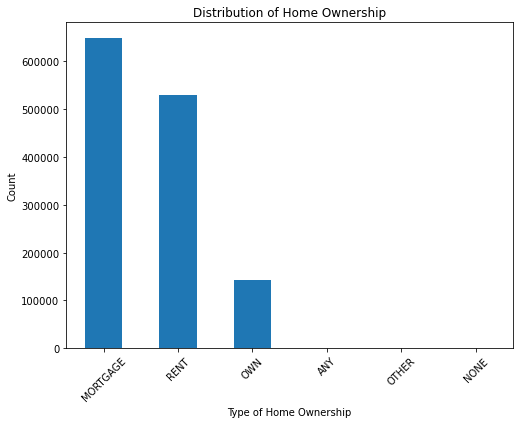

In [20]:
plt.figure(figsize = (8,6))
loan['home_ownership'].value_counts().plot(kind = 'bar')
plt.xlabel('Type of Home Ownership')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.title('Distribution of Home Ownership');

##### Loan Purpose

There doesn't appear to be any null values in our loan purpose column, but it is interesting to note that the majority of loans were used for debt consolidation with small business being the runner up. 

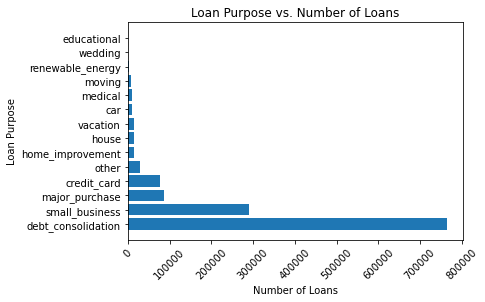

In [21]:
plt.barh(loan['purpose'].unique(), loan['purpose'].value_counts())
plt.xlabel('Number of Loans', size = 10)
plt.ylabel('Loan Purpose', size = 10)
plt.xticks(rotation = 45)
plt.title('Loan Purpose vs. Number of Loans');

##### Earliest Credit Line 

By using both the datetimes from earliest credit line and the issued loan date, we can engineer a feature that represents the credit files age. The credit file age will be the year the loan was issued minus the year they had their earliest credit line which usually indicates when someone started their credit history. We will then drop the datetime columns before we export for modeling. 

In [22]:
loan['earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'])
loan['earliest_cr_line_year'] = loan['earliest_cr_line'].dt.year
loan['year'] = loan['issue_d'].dt.year
loan['credit_file_age'] = loan['year'] - loan['earliest_cr_line_year']

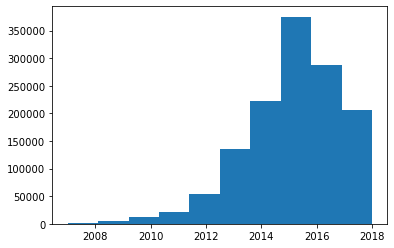

In [23]:
plt.hist(loan['year']);

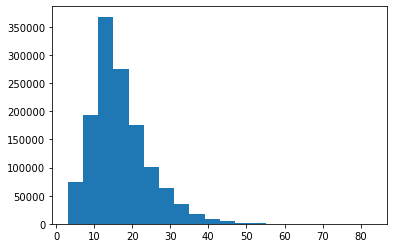

In [24]:
plt.hist(loan['credit_file_age'], bins = 20);

In [25]:
loan.drop(columns = ['earliest_cr_line', 'application_type', 'year', 'earliest_cr_line_year'], inplace = True)

In [26]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319510 entries, 0 to 2260697
Data columns (total 29 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   loan_amnt             1319510 non-null  float64       
 1   term                  1319510 non-null  int64         
 2   int_rate              1319510 non-null  float64       
 3   installment           1319510 non-null  float64       
 4   emp_length            1319510 non-null  object        
 5   home_ownership        1319510 non-null  object        
 6   annual_inc            1319510 non-null  float64       
 7   issue_d               1319510 non-null  datetime64[ns]
 8   loan_status           1319510 non-null  int64         
 9   purpose               1319510 non-null  object        
 10  dti                   1319510 non-null  float64       
 11  delinq_2yrs           1319510 non-null  float64       
 12  fico_range_low        1319510 non-null  fl

##### FICO

We expect FICO to be a major part in predicting whether someone will repay their loan in full or charge-off. However, this origianl dataset provides it to us in the form of a range. We will create a new column 'FICO' using the average of these two values to just capture a singular FICO value. 

In [27]:
loan[['last_fico_range_high', 'last_fico_range_low']]

,last_fico_range_high,last_fico_range_low
0,564.0,560.0
1,699.0,695.0
4,704.0,700.0
5,759.0,755.0
6,654.0,650.0
...,...,...
2260688,709.0,705.0
2260690,719.0,715.0
2260691,499.0,0.0
2260692,684.0,680.0


In [28]:
loan['fico'] = loan[['last_fico_range_high', 'last_fico_range_low']].mean(axis = 1)

In [29]:
loan[['fico', 'last_fico_range_high', 'last_fico_range_low']]

,fico,last_fico_range_high,last_fico_range_low
0,562.0,564.0,560.0
1,697.0,699.0,695.0
4,702.0,704.0,700.0
5,757.0,759.0,755.0
6,652.0,654.0,650.0
...,...,...,...
2260688,707.0,709.0,705.0
2260690,717.0,719.0,715.0
2260691,249.5,499.0,0.0
2260692,682.0,684.0,680.0


In [30]:
loan.drop(columns = ['last_fico_range_high', 'last_fico_range_low'], inplace = True)

#### Missing Values

From isolating the types of applications to 'Individual' as well as cutting down the loans in our dataset to "Fully Paid" or "Charged Off", we've reduced the number of missing values from a variety of columns. But, there still remains seven columns with missing values.

Our first strategy would be to drop all null values due to the size of our dataset which is generally not the best method of dealing with null values as we are dropping all other related features associated with a loan. 

Our second strategy would be to impute the values with a mean, median, or mode depending on the data type of the feature. Mode would be useful for categorical features, the median for discrete numerical features, and the mean for continuous numerical features -- while also accounting for outliers. 

We will first see how our initial logistic regression does on two versions of our data: one where we drop our null values, and one where we impute them with respective values. 


In [31]:
null_count = []
for columns in loan.columns[0:100]:
    if loan[columns].isna().sum() != 0:
        print('FEATURE NAME:')
        print(columns)
        print('FEATURE TYPE:')
        print(loan[columns].dtype)
        print('NULL VALUE COUNT:')
        print(loan[columns].isna().sum())
        print('PERCENT OF ALL VALUES:')
        print(loan[columns].isna().sum() / len(loan[columns]))
        print('~~~~~~~~~~~~~~~~~~~')
        null_count.append([columns, loan[columns].isna().sum(), loan[columns].isnull().mean()])
null_values = pd.DataFrame(null_count, columns = ['Feature', 'Null Value Count', 'Percentage of Data'])

FEATURE NAME:
inq_last_6mths
FEATURE TYPE:
float64
NULL VALUE COUNT:
1
PERCENT OF ALL VALUES:
7.578570833112292e-07
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
revol_util
FEATURE TYPE:
float64
NULL VALUE COUNT:
812
PERCENT OF ALL VALUES:
0.000615379951648718
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
avg_cur_bal
FEATURE TYPE:
float64
NULL VALUE COUNT:
67546
PERCENT OF ALL VALUES:
0.051190214549340286
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
pub_rec_bankruptcies
FEATURE TYPE:
float64
NULL VALUE COUNT:
697
PERCENT OF ALL VALUES:
0.0005282263870679268
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
tax_liens
FEATURE TYPE:
float64
NULL VALUE COUNT:
39
PERCENT OF ALL VALUES:
2.9556426249137938e-05
~~~~~~~~~~~~~~~~~~~
FEATURE NAME:
mort_acc
FEATURE TYPE:
float64
NULL VALUE COUNT:
47281
PERCENT OF ALL VALUES:
0.035832240756038226
~~~~~~~~~~~~~~~~~~~


In [32]:
#Creating a dataframe where all null values are dropped
dropped_loan = loan.dropna(axis = 0)

In [33]:
(loan.shape[0] - dropped_loan.shape[0]) / loan.shape[0]

0.05173056664974119

In dropping all rows with null values, we lost 5.17% of our original dataframe which isn't a large amount, but losing data in general is not preferrable.

In [34]:
loan['inq_last_6mths'].value_counts(dropna = False)

0.0    753705
1.0    360217
2.0    134758
3.0     51150
4.0     13796
5.0      4872
6.0       941
7.0        48
8.0        22
NaN         1
Name: inq_last_6mths, dtype: int64

In [35]:
loan['inq_last_6mths'].fillna(stats.mode(loan['inq_last_6mths'])[0][0], inplace = True)

In [36]:
loan['inq_last_6mths'].value_counts(dropna = False)

0.0    753706
1.0    360217
2.0    134758
3.0     51150
4.0     13796
5.0      4872
6.0       941
7.0        48
8.0        22
Name: inq_last_6mths, dtype: int64

In [37]:
loan.revol_util.value_counts(dropna = False)

0.0      6642
57.0     2623
58.0     2602
53.0     2595
54.0     2595
         ... 
129.5       1
118.9       1
118.2       1
114.9       1
139.9       1
Name: revol_util, Length: 1372, dtype: int64

C:\Users\eddie\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='revol_util', ylabel='Density'>

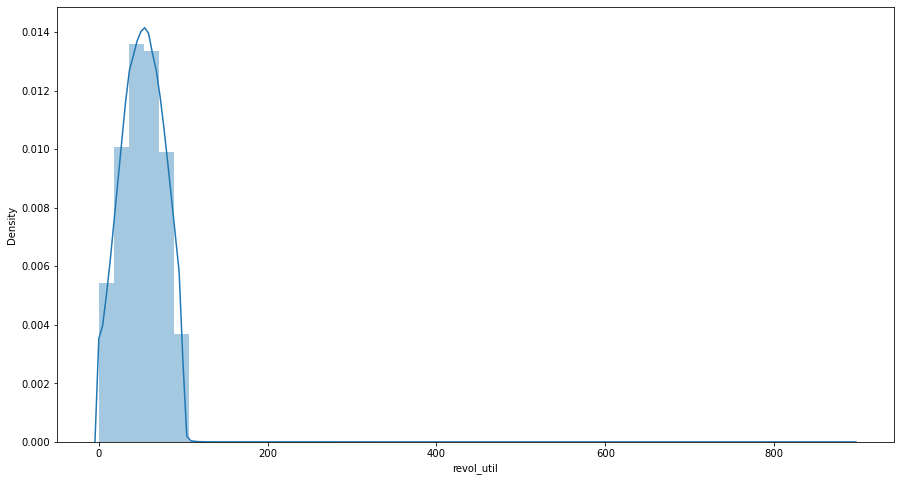

In [38]:
plt.figure(figsize = (15,8))
sns.distplot(loan['revol_util'])

In [39]:
loan[loan['revol_util'].isnull()]

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,issue_d,loan_status,purpose,...,revol_bal,revol_util,acc_now_delinq,avg_cur_bal,delinq_amnt,pub_rec_bankruptcies,tax_liens,mort_acc,credit_file_age,fico
1537,6000.0,0,10.78,195.81,5-10 years,OWN,50000.0,2015-12-01,0,home_improvement,...,0.0,NaN,0.0,53837.0,0.0,0.0,0.0,2.0,13,632.0
3577,20000.0,0,11.48,659.33,10+ years,MORTGAGE,370000.0,2015-12-01,0,debt_consolidation,...,488.0,NaN,0.0,17252.0,0.0,0.0,0.0,1.0,14,627.0
5674,6200.0,0,8.49,195.70,1-5 years,MORTGAGE,44800.0,2015-12-01,0,debt_consolidation,...,6424.0,NaN,0.0,22215.0,0.0,0.0,0.0,4.0,11,662.0
6781,19200.0,0,18.49,698.86,10+ years,RENT,142000.0,2015-12-01,1,small_business,...,0.0,NaN,0.0,9873.0,0.0,0.0,0.0,1.0,19,577.0
12432,12000.0,0,19.99,445.91,1-5 years,RENT,150000.0,2015-12-01,0,debt_consolidation,...,0.0,NaN,0.0,12458.0,0.0,0.0,0.0,3.0,14,702.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248332,13000.0,1,17.99,330.05,<1 year,RENT,44000.0,2016-10-01,0,debt_consolidation,...,0.0,NaN,0.0,2927.0,0.0,0.0,0.0,0.0,12,707.0
2254626,6025.0,0,11.49,198.66,1-5 years,RENT,48000.0,2016-10-01,0,car,...,0.0,NaN,0.0,15481.0,0.0,0.0,0.0,0.0,9,662.0
2256309,3600.0,0,17.99,130.14,1-5 years,OWN,85000.0,2016-10-01,1,debt_consolidation,...,47622.0,NaN,0.0,82082.0,0.0,0.0,0.0,1.0,13,507.0
2257114,10000.0,0,18.99,366.51,10+ years,MORTGAGE,50000.0,2016-10-01,0,debt_consolidation,...,0.0,NaN,0.0,54470.0,0.0,0.0,0.0,2.0,13,667.0


In [40]:
loan['revol_util'].fillna(np.mean(loan['revol_util']), inplace = True)

In [41]:
stats.mode(loan['avg_cur_bal'])[0][0]

0.0

In [42]:
loan['avg_cur_bal'].value_counts()

0.0         342
1971.0      171
2606.0      163
2253.0      162
2831.0      160
           ... 
63486.0       1
91915.0       1
103029.0      1
54790.0       1
72812.0       1
Name: avg_cur_bal, Length: 76198, dtype: int64

C:\Users\eddie\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_cur_bal', ylabel='Density'>

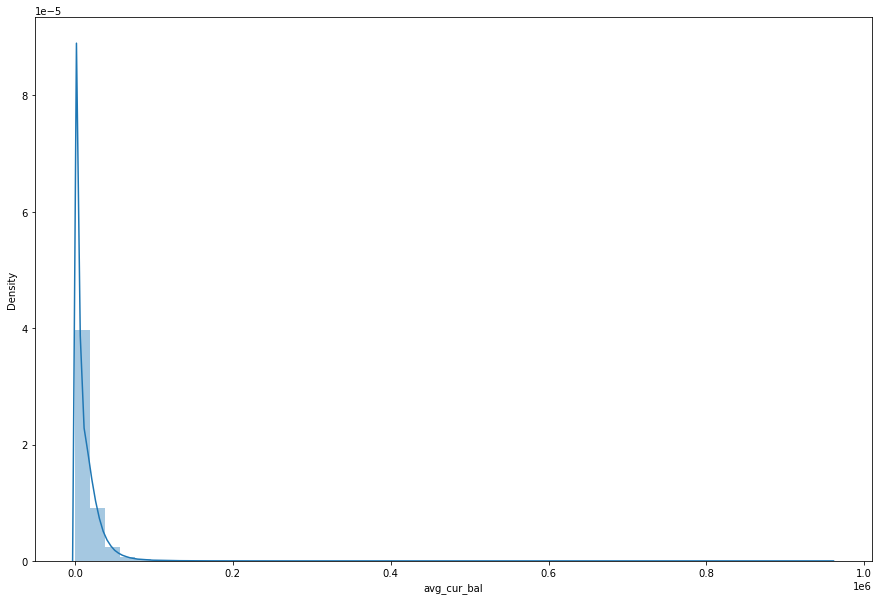

In [43]:
plt.figure(figsize = (15, 10))
sns.distplot(loan['avg_cur_bal'])

In [44]:
loan['avg_cur_bal'].fillna(stats.mode(loan['avg_cur_bal'])[0][0], inplace = True)

C:\Users\eddie\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pub_rec_bankruptcies', ylabel='Density'>

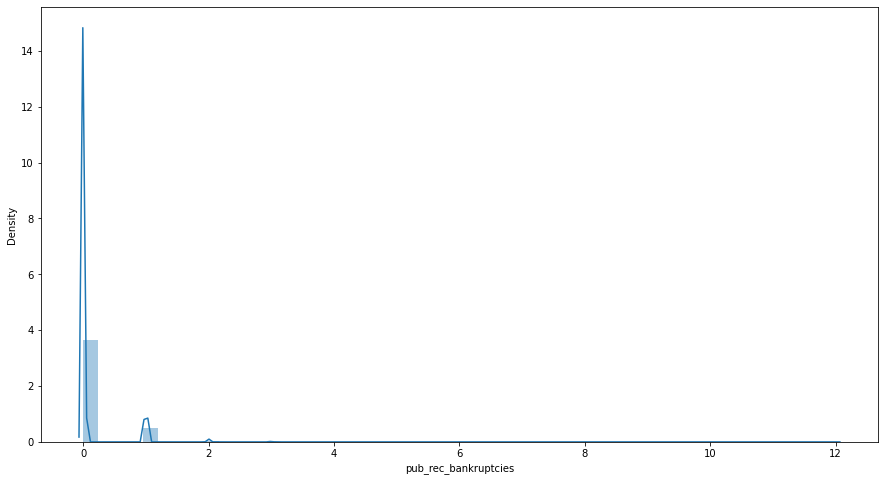

In [46]:
plt.figure(figsize = (15, 8))
sns.distplot(loan['pub_rec_bankruptcies'])

In [47]:
loan['pub_rec_bankruptcies'].value_counts(dropna = False)

0.0     1155108
1.0      153874
2.0        7653
3.0        1568
NaN         697
4.0         395
5.0         141
6.0          45
7.0          15
8.0           9
9.0           3
11.0          1
12.0          1
Name: pub_rec_bankruptcies, dtype: int64

In [48]:
loan['pub_rec_bankruptcies'].fillna(stats.mode(loan['pub_rec_bankruptcies'])[0][0], inplace = True)

In [49]:
loan['tax_liens'].median()

0.0

In [50]:
loan['tax_liens'].value_counts(dropna = False)

0.0     1276730
1.0       29082
2.0        8003
3.0        2842
4.0        1301
5.0         674
6.0         354
7.0         176
8.0          88
9.0          61
10.0         47
NaN          39
11.0         29
12.0         20
13.0          8
15.0          8
17.0          6
18.0          5
16.0          5
21.0          4
14.0          4
27.0          3
22.0          3
20.0          3
46.0          2
24.0          2
34.0          1
23.0          1
53.0          1
48.0          1
85.0          1
63.0          1
39.0          1
37.0          1
45.0          1
19.0          1
61.0          1
Name: tax_liens, dtype: int64

In [51]:
loan['tax_liens'] = loan['tax_liens'].fillna(loan['tax_liens'].median())

C:\Users\eddie\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mort_acc', ylabel='Density'>

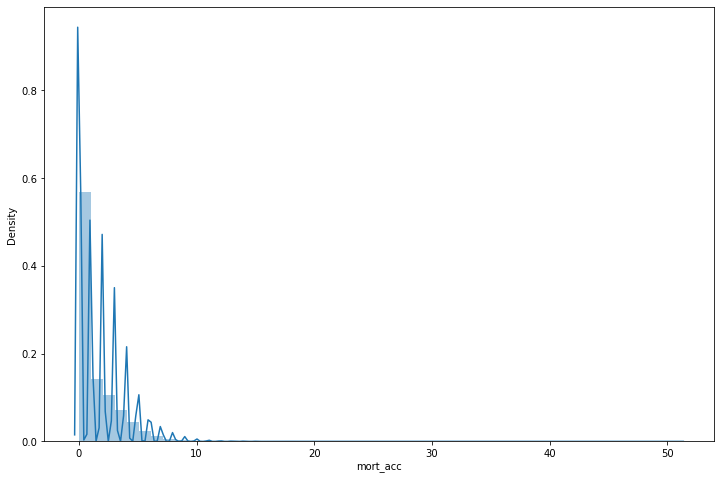

In [52]:
plt.figure(figsize = (12, 8))
sns.distplot(loan['mort_acc'])

In [53]:
loan['mort_acc'].value_counts(dropna = False)

0.0     516371
1.0     220731
2.0     184160
3.0     135917
4.0      92681
5.0      56377
NaN      47281
6.0      31902
7.0      16550
8.0       8253
9.0       4218
10.0      2172
11.0      1186
12.0       634
13.0       352
14.0       240
15.0       131
16.0        93
17.0        61
18.0        47
19.0        28
20.0        25
24.0        16
21.0        14
22.0        14
23.0        10
25.0         9
27.0         8
26.0         6
29.0         4
28.0         4
34.0         3
32.0         2
30.0         2
37.0         2
31.0         2
47.0         1
51.0         1
36.0         1
35.0         1
Name: mort_acc, dtype: int64

In [54]:
loan.mort_acc = loan.mort_acc.fillna(loan.mort_acc.median())

In [55]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319510 entries, 0 to 2260697
Data columns (total 28 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   loan_amnt             1319510 non-null  float64       
 1   term                  1319510 non-null  int64         
 2   int_rate              1319510 non-null  float64       
 3   installment           1319510 non-null  float64       
 4   emp_length            1319510 non-null  object        
 5   home_ownership        1319510 non-null  object        
 6   annual_inc            1319510 non-null  float64       
 7   issue_d               1319510 non-null  datetime64[ns]
 8   loan_status           1319510 non-null  int64         
 9   purpose               1319510 non-null  object        
 10  dti                   1319510 non-null  float64       
 11  delinq_2yrs           1319510 non-null  float64       
 12  fico_range_low        1319510 non-null  fl

In [62]:
loan.drop(columns = ['issue_d', 'fico_range_low', 'fico_range_high'], inplace = True)

In [74]:
loan.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1319510.0,14330.596547,8659.026370,500.00,7800.00,12000.00,20000.00,40000.00
term,1319510.0,0.238750,0.426320,0.00,0.00,0.00,0.00,1.00
int_rate,1319510.0,13.212901,4.744419,5.31,9.75,12.74,15.99,30.99
installment,1319510.0,435.579558,259.806339,4.93,247.37,373.22,576.51,1719.83
annual_inc,1319510.0,76609.930724,70335.869873,2000.00,46000.00,65000.00,90764.80,10999200.00
loan_status,1319510.0,0.198721,0.399038,0.00,0.00,0.00,0.00,1.00
dti,1319510.0,18.015555,8.368122,-1.00,11.75,17.53,23.90,49.96
delinq_2yrs,1319510.0,0.318236,0.878466,0.00,0.00,0.00,0.00,39.00
inq_last_6mths,1319510.0,0.658491,0.940685,0.00,0.00,0.00,1.00,8.00
open_acc,1319510.0,11.601915,5.474333,0.00,8.00,11.00,14.00,90.00


In [76]:
loan.acc_now_delinq.value_counts()

0.0     1313251
1.0        5902
2.0         300
3.0          42
4.0          10
5.0           3
6.0           1
14.0          1
Name: acc_now_delinq, dtype: int64

(array([1.314538e+06, 4.597000e+03, 3.040000e+02, 5.100000e+01,
        1.500000e+01, 3.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 1.000000e+00]),
 array([     0. ,  95808.4, 191616.8, 287425.2, 383233.6, 479042. ,
        574850.4, 670658.8, 766467.2, 862275.6, 958084. ]),
 <BarContainer object of 10 artists>)

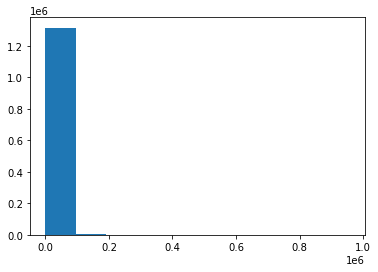

In [75]:
plt.hist(loan['avg_cur_bal'])

Dealing with null values:
- Possibly remove missing values (not recommended)
- Impute null with median
- Longer: Find relationship between features that share similar number of null values to see if there is a pattern and determine what can be imputed to reflect accurate info from participant (we can see this for number of accounts so it does not appear to be completely at random..just a guess)
- Checking correlation between features to drop ones that are experiencing severe multicollinearity

To 

We can see that for those that have no employment title provided also happen to be ~90% of those that reported no employment length. This may show that those with no employment length are never employed, self-employed, students or possibly retired. Due to this, we will keep these values of 'n/a' in employment length as their own category. We will be dropping the emp_title column due to the high number of unique titles (371,436).

In [73]:
loan.reset_index(drop = True)

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,loan_status,purpose,dti,...,revol_bal,revol_util,acc_now_delinq,avg_cur_bal,delinq_amnt,pub_rec_bankruptcies,tax_liens,mort_acc,credit_file_age,fico
0,3600.0,0,13.99,123.03,10+ years,MORTGAGE,55000.0,0,debt_consolidation,5.91,...,2765.0,29.7,0.0,20701.0,0.0,0.0,0.0,1.0,12,562.0
1,24700.0,0,11.99,820.28,10+ years,MORTGAGE,65000.0,0,small_business,16.06,...,21470.0,19.2,0.0,9733.0,0.0,0.0,0.0,4.0,16,697.0
2,10400.0,1,22.45,289.91,1-5 years,MORTGAGE,104433.0,0,major_purchase,25.37,...,21929.0,64.5,0.0,27644.0,0.0,0.0,0.0,6.0,17,702.0
3,11950.0,0,13.44,405.18,1-5 years,RENT,34000.0,0,debt_consolidation,10.20,...,8822.0,68.4,0.0,2560.0,0.0,0.0,0.0,0.0,28,757.0
4,20000.0,0,9.17,637.58,10+ years,MORTGAGE,180000.0,0,debt_consolidation,14.67,...,87329.0,84.5,0.0,30030.0,0.0,0.0,0.0,4.0,25,652.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319505,18000.0,1,9.49,377.95,1-5 years,OWN,130000.0,0,home_improvement,20.59,...,23833.0,34.0,0.0,9927.0,0.0,0.0,0.0,3.0,12,707.0
1319506,29400.0,1,13.99,683.94,5-10 years,MORTGAGE,180792.0,0,debt_consolidation,22.03,...,77480.0,85.2,0.0,44231.0,0.0,0.0,0.0,3.0,14,717.0
1319507,32000.0,1,14.49,752.74,1-5 years,MORTGAGE,157000.0,1,home_improvement,10.34,...,111598.0,27.4,0.0,29193.0,0.0,0.0,0.0,3.0,5,249.5
1319508,16000.0,1,12.79,362.34,10+ years,RENT,150000.0,0,medical,12.25,...,7700.0,55.0,0.0,5982.0,0.0,3.0,0.0,0.0,19,682.0


In [77]:
loan.shape

(1319510, 25)

In [78]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319510 entries, 0 to 2260697
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1319510 non-null  float64
 1   term                  1319510 non-null  int64  
 2   int_rate              1319510 non-null  float64
 3   installment           1319510 non-null  float64
 4   emp_length            1319510 non-null  object 
 5   home_ownership        1319510 non-null  object 
 6   annual_inc            1319510 non-null  float64
 7   loan_status           1319510 non-null  int64  
 8   purpose               1319510 non-null  object 
 9   dti                   1319510 non-null  float64
 10  delinq_2yrs           1319510 non-null  float64
 11  inq_last_6mths        1319510 non-null  float64
 12  open_acc              1319510 non-null  float64
 13  total_acc             1319510 non-null  float64
 14  pub_rec               1319510 non-

In [93]:
loan['log_annual_inc'] = np.log(loan['annual_inc'])
loan.drop(columns = ['annual_inc'], inplace = True)

In [79]:
drop_categorical = ['emp_length', 'home_ownership', 'purpose']
dummies = pd.get_dummies(loan, columns = drop_categorical, drop_first = True)

In [94]:
all_cols = list(loan.columns)

In [95]:
for d in drop_categorical:
    all_cols.remove(d)

In [97]:
all_cols.remove('loan_status')

In [101]:
loan.to_csv('./data/loan_all.csv')

In [99]:
loan.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,loan_status,purpose,dti,delinq_2yrs,...,revol_util,acc_now_delinq,avg_cur_bal,delinq_amnt,pub_rec_bankruptcies,tax_liens,mort_acc,credit_file_age,fico,log_annual_inc
0,3600.0,0,13.99,123.03,10+ years,MORTGAGE,0,debt_consolidation,5.91,0.0,...,29.7,0.0,20701.0,0.0,0.0,0.0,1.0,12,562.0,10.915088
1,24700.0,0,11.99,820.28,10+ years,MORTGAGE,0,small_business,16.06,1.0,...,19.2,0.0,9733.0,0.0,0.0,0.0,4.0,16,697.0,11.082143
4,10400.0,1,22.45,289.91,1-5 years,MORTGAGE,0,major_purchase,25.37,1.0,...,64.5,0.0,27644.0,0.0,0.0,0.0,6.0,17,702.0,11.556301
5,11950.0,0,13.44,405.18,1-5 years,RENT,0,debt_consolidation,10.20,0.0,...,68.4,0.0,2560.0,0.0,0.0,0.0,0.0,28,757.0,10.434116
6,20000.0,0,9.17,637.58,10+ years,MORTGAGE,0,debt_consolidation,14.67,0.0,...,84.5,0.0,30030.0,0.0,0.0,0.0,4.0,25,652.0,12.100712


In [98]:
all_cols

['loan_amnt',
 'term',
 'int_rate',
 'installment',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'total_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'acc_now_delinq',
 'avg_cur_bal',
 'delinq_amnt',
 'pub_rec_bankruptcies',
 'tax_liens',
 'mort_acc',
 'credit_file_age',
 'fico',
 'log_annual_inc']

In [80]:
dummies

,loan_amnt,term,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,3600.0,0,13.99,123.03,55000.0,0,5.91,0.0,1.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,24700.0,0,11.99,820.28,65000.0,0,16.06,1.0,4.0,22.0,...,0,0,0,0,0,0,0,1,0,0
4,10400.0,1,22.45,289.91,104433.0,0,25.37,1.0,3.0,12.0,...,0,0,1,0,0,0,0,0,0,0
5,11950.0,0,13.44,405.18,34000.0,0,10.20,0.0,0.0,5.0,...,0,0,0,0,0,0,0,0,0,0
6,20000.0,0,9.17,637.58,180000.0,0,14.67,0.0,0.0,12.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,18000.0,1,9.49,377.95,130000.0,0,20.59,0.0,1.0,17.0,...,1,0,0,0,0,0,0,0,0,0
2260690,29400.0,1,13.99,683.94,180792.0,0,22.03,0.0,1.0,16.0,...,0,0,0,0,0,0,0,0,0,0
2260691,32000.0,1,14.49,752.74,157000.0,1,10.34,0.0,0.0,14.0,...,1,0,0,0,0,0,0,0,0,0
2260692,16000.0,1,12.79,362.34,150000.0,0,12.25,0.0,0.0,12.0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
plt.hist(loan.loan_amnt, bins = 10)
plt.axvline(np.mean(loan.loan_amnt), color = 'red')
plt.xlabel('Loan Amount in USD')
plt.ylabel('Values')
plt.title('Distribution of Loan Amount');

In [ ]:
plt.hist(loan.int_rate, bins = 15)
plt.axvline(np.mean(loan.int_rate), color = 'red')
plt.xlabel('Interest Rate')
plt.ylabel('Values')
plt.title('Distribution of Interest Rate');

In [ ]:
plt.hist(loan.installment, bins = 15)
plt.axvline(np.mean(loan.installment), color = 'red')
plt.xlabel('Payment Installment Size')
plt.title('Distribution of Installment Size');

In [ ]:
plt.hist(loan.annual_inc, bins = 2000)
plt.axvline(np.mean(loan.annual_inc), color = 'red')
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.xlabel('Annual Income in USD')
plt.ylabel('Values')
plt.title('Distribution of Annual Income');

In [ ]:
log_annual = np.log(loan.annual_inc)

In [ ]:
loan[loan.annual_inc == 0.0][

In [ ]:
plt.hist(log_annual)
plt.axvline(np.log(np.mean(loan.annual_inc)), color = 'red')
plt.ticklabel_format(style='plain', axis='x',useOffset=False)
plt.xlabel('Annual Income in USD')
plt.ylabel('Values')
plt.title('Distribution of Annual Income');

In [ ]:
sns.catplot(x = 'loan_status', kind = 'count', data = loan)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.title('Loan Status Breakdown')
plt.xlabel('Loan Status');

Large class imbalance we can see with our dependent variable. Loans that charged-off amount to 261,655 and loans that were fully paid amount to 1,041,952. In simple terms, there are ~4 times as many examples of loans that were fully paid off. Due to the class imbalance, we probably would not use our accuracy score considering if we guessed for all the loans to be fully paid off, we would be accurate at 79.93%. With that, we will use the precision-recall AUC score as it evaluates the faction of true positives among positive predictions.

In [ ]:
1041952/261655

In [ ]:
loan.describe().T.head(30)

### Models:
- Log Reg, tune for regularization
- Random Forest Classifier, bagging, diverse set of potential trees to be built
- KNN
- Naive Bayes(?) - independence of features, need to deal with multicoll.
- SVM
- Deep Neural Network

In [102]:
loan.corr()

,loan_amnt,term,int_rate,installment,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,total_acc,...,revol_util,acc_now_delinq,avg_cur_bal,delinq_amnt,pub_rec_bankruptcies,tax_liens,mort_acc,credit_file_age,fico,log_annual_inc
loan_amnt,1.000000,0.380260,0.139864,0.953760,0.065764,0.022779,-0.002620,-0.012747,0.187875,0.211655,...,0.109936,0.001752,0.232654,0.000562,-0.096257,0.008083,0.225535,0.161972,0.050347,0.511527
term,0.380260,1.000000,0.417630,0.142535,0.177141,0.068630,-0.008165,0.022191,0.072180,0.100773,...,0.065630,0.000314,0.073881,-0.000687,-0.011480,-0.011916,0.098925,0.034351,-0.086344,0.124048
int_rate,0.139864,0.417630,1.000000,0.150763,0.258898,0.181363,0.048118,0.217688,-0.004471,-0.041725,...,0.243193,0.017743,-0.076007,0.005449,0.058544,0.012230,-0.078320,-0.118051,-0.313971,-0.112782
installment,0.953760,0.142535,0.150763,1.000000,0.051339,0.027777,0.006593,0.009149,0.177915,0.188425,...,0.127571,0.004497,0.209038,0.001583,-0.088302,0.015030,0.194246,0.143798,0.038731,0.488518
loan_status,0.065764,0.177141,0.258898,0.051339,1.000000,0.109143,0.019395,0.066250,0.029320,-0.010215,...,0.060728,0.004021,-0.070953,0.002814,0.025508,0.009893,-0.071918,-0.033826,-0.636465,-0.064793
dti,0.022779,0.068630,0.181363,0.027777,0.109143,1.000000,-0.008686,-0.002534,0.297645,0.231972,...,0.183945,0.005133,-0.100000,-0.005550,-0.027431,-0.028547,-0.034898,0.051233,-0.079946,-0.211170
delinq_2yrs,-0.002620,-0.008165,0.048118,0.006593,0.019395,-0.008686,1.000000,0.024116,0.052861,0.119651,...,-0.011667,0.124537,0.052058,0.030187,-0.046913,0.011171,0.075368,0.085312,-0.052169,0.069631
inq_last_6mths,-0.012747,0.022191,0.217688,0.009149,0.066250,-0.002534,0.024116,1.000000,0.134405,0.149844,...,-0.082865,-0.003754,-0.028176,0.001009,0.075006,0.009668,0.042973,0.000758,-0.089180,0.049217
open_acc,0.187875,0.072180,-0.004471,0.177915,0.029320,0.297645,0.052861,0.134405,1.000000,0.700885,...,-0.142028,0.019975,-0.090652,0.004390,-0.023373,-0.004487,0.124106,0.144871,0.018005,0.235532
total_acc,0.211655,0.100773,-0.041725,0.188425,-0.010215,0.231972,0.119651,0.149844,0.700885,1.000000,...,-0.106335,0.027412,0.063373,0.006895,0.034198,-0.019169,0.364259,0.281343,0.075031,0.307476


In [103]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319510 entries, 0 to 2260697
Data columns (total 25 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1319510 non-null  float64
 1   term                  1319510 non-null  int64  
 2   int_rate              1319510 non-null  float64
 3   installment           1319510 non-null  float64
 4   emp_length            1319510 non-null  object 
 5   home_ownership        1319510 non-null  object 
 6   loan_status           1319510 non-null  int64  
 7   purpose               1319510 non-null  object 
 8   dti                   1319510 non-null  float64
 9   delinq_2yrs           1319510 non-null  float64
 10  inq_last_6mths        1319510 non-null  float64
 11  open_acc              1319510 non-null  float64
 12  total_acc             1319510 non-null  float64
 13  pub_rec               1319510 non-null  float64
 14  revol_bal             1319510 non-

In [104]:
X = loan.drop(columns = ['loan_status'])
y = loan['loan_status']

In [105]:
X = pd.get_dummies(X, drop_first = True)

In [107]:
X.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'total_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'acc_now_delinq', 'avg_cur_bal', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'mort_acc', 'credit_file_age',
       'fico', 'log_annual_inc', 'emp_length_10+ years',
       'emp_length_5-10 years', 'emp_length_<1 year', 'emp_length_N/A',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, stratify = y, random_state = 42)

In [113]:
ss = StandardScaler()

In [118]:
X_train[all_cols] = ss.fit_transform(X_train[all_cols])

C:\Users\eddie\anaconda3\lib\site-packages\pandas\core\frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [120]:
X_test[all_cols] = ss.transform(X_test[all_cols])

C:\Users\eddie\anaconda3\lib\site-packages\pandas\core\frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [121]:
from sklearn.linear_model import LogisticRegression

In [122]:
lr = LogisticRegression()

In [123]:
lr.fit(X_train, y_train)

C:\Users\eddie\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [124]:
lr.score(X_train, y_train)

0.9020877068002516

In [126]:
lr.score(X_test, y_test)

0.801278504899546

In [128]:
preds = lr.predict(X_test)

In [129]:
from sklearn.metrics import accuracy_score

In [130]:
accuracy_score(y_test, preds)

0.801278504899546